## Sentence Similarity

Word embeddings have become widespread in Natural Language Processing. They allow us to easily compute the semantic similarity between two words, or to find the words most similar to a target word. However, in many applications we're more interested in the similarity between two sentences or short texts. There are many ways to compare similarities of 2 texts using traditional methods like edit distance as well as using deep learning neural networks. In this notebook, I compare some simple ways of computing sentence similarity using word vectors and investigate how they perform.


### Loading Data
#### STS Benchmark
The STS Benchmark brings together the English data from the SemEval sentence similarity tasks between 2012 and 2017. The data is split in training, development and test data: http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark

In [31]:
from preprocessing.load_data import download_and_load_sts_data, download_and_load_sick_dataset

sts_dev, sts_test = download_and_load_sts_data()
sts_test[:10]

,sent_1,sent_2,sim
0,A girl is styling her hair.,A girl is brushing her hair.,2.500
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,3.600
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,5.000
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,4.200
4,A man is playing a harp.,A man is playing a keyboard.,1.500
5,A woman is cutting onions.,A woman is cutting tofu.,1.800
6,A man is riding an electric bicycle.,A man is riding a bicycle.,3.500
7,A man is playing the drums.,A man is playing the guitar.,2.200
8,A man is playing guitar.,A lady is playing the guitar.,2.200
9,A man is playing a guitar.,A man is playing a trumpet.,1.714


#### SICK data
The SICK dataset contains 10,000 English sentence pairs labelled with their semantic relatedness and entailment relation.

In [2]:
sick_all, sick_train, sick_test, sick_dev = download_and_load_sick_dataset()
sick_all[:10]

,idx,sent_1,sent_2,sim,label
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,4.5,NEUTRAL
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,3.2,NEUTRAL
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,4.7,ENTAILMENT
3,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,3.4,NEUTRAL
4,9,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,3.7,NEUTRAL
5,12,Two dogs are fighting,Two dogs are wrestling and hugging,4.0,NEUTRAL
6,14,A brown dog is attacking another animal in fro...,Two dogs are fighting,3.5,NEUTRAL
7,18,A brown dog is attacking another animal in fro...,Two dogs are wrestling and hugging,3.2,NEUTRAL
8,25,Nobody is riding the bicycle on one wheel,A person in a black jacket is doing tricks on ...,2.8,NEUTRAL
9,26,A person is riding the bicycle on one wheel,A man in a black jacket is doing tricks on a m...,3.7,NEUTRAL


### Loading Embeddings
2 word embeddings were used for this experiment. Word2vec and Glove. 

#### Loading word2vec

In [3]:
from embeddings.load_embeddings import load_word2vec
word2vec = load_word2vec("/data/word2vec/GoogleNews-vectors-negative300.bin.gz")

#### Loading Glove
To load Glove, we have to convert the downloaded GloVe file to word2vec format and then load the embeddings into a Gensim model. 

In [4]:
from embeddings.load_embeddings import load_glove
glove = load_glove("/data/glove/glove.840B.300d.txt")

#### Loading Frequencies
To weight the word vectors we need frequency stat. For that we used word frequencies that have been collected from Wikipedia. 

In [5]:
from utility.frequency_loader import load_frequencies, load_doc_frequencies

frequency = load_frequencies("/data/frequencies/frequencies.tsv")
doc_frequency = load_doc_frequencies("/data/frequencies/doc_frequencies.tsv")

### Vector Average
As our first similarity measure we are going to use vector average. Then take the embeddings of the words and calcluate the average to get a vector for the sentence. There are few benchmarks we created.
1. Calculating the average considering all the words. 
2. Calculating the average removing stop words.
3. Calculating the average while weighting the words with inverse document frequency.
4. Calculating the average while weighting the words with inverse document frequency and removing the stop words. 

These experiments were done using both word2vec and Glove. 

In [6]:
import functools as ft
from preprocessing.normalize import normalize
from matrices.avg_embeddings import run_avg_benchmark
from utility.run_experiment import run_experiment
import pandas as pd
import matplotlib.pyplot as plt


benchmarks = [("AVG-W2V", ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=False)),
              ("AVG-W2V-STOP", ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=True)),
              ("AVG-W2V-TFIDF", ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=False, doc_freqs=doc_frequency)),
              ("AVG-W2V-TFIDF-STOP",ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=True, doc_freqs=doc_frequency)),
              ("AVG-GLOVE", ft.partial(run_avg_benchmark, model=glove, use_stoplist=False)),
              ("AVG-GLOVE-STOP", ft.partial(run_avg_benchmark, model=glove, use_stoplist=True)),
              ("AVG-GLOVE-TFIDF", ft.partial(run_avg_benchmark, model=glove, use_stoplist=False, doc_freqs=doc_frequency)),
              ("AVG-GLOVE-TFIDF-STOP",ft.partial(run_avg_benchmark, model=glove, use_stoplist=True, doc_freqs=doc_frequency))]


Method was tested for SICK dataset. Only the training sample was used. Pearson Correlation and Spearman Correlation was used between the actual similarity and predicted similarity to evaluate the benchmark. 

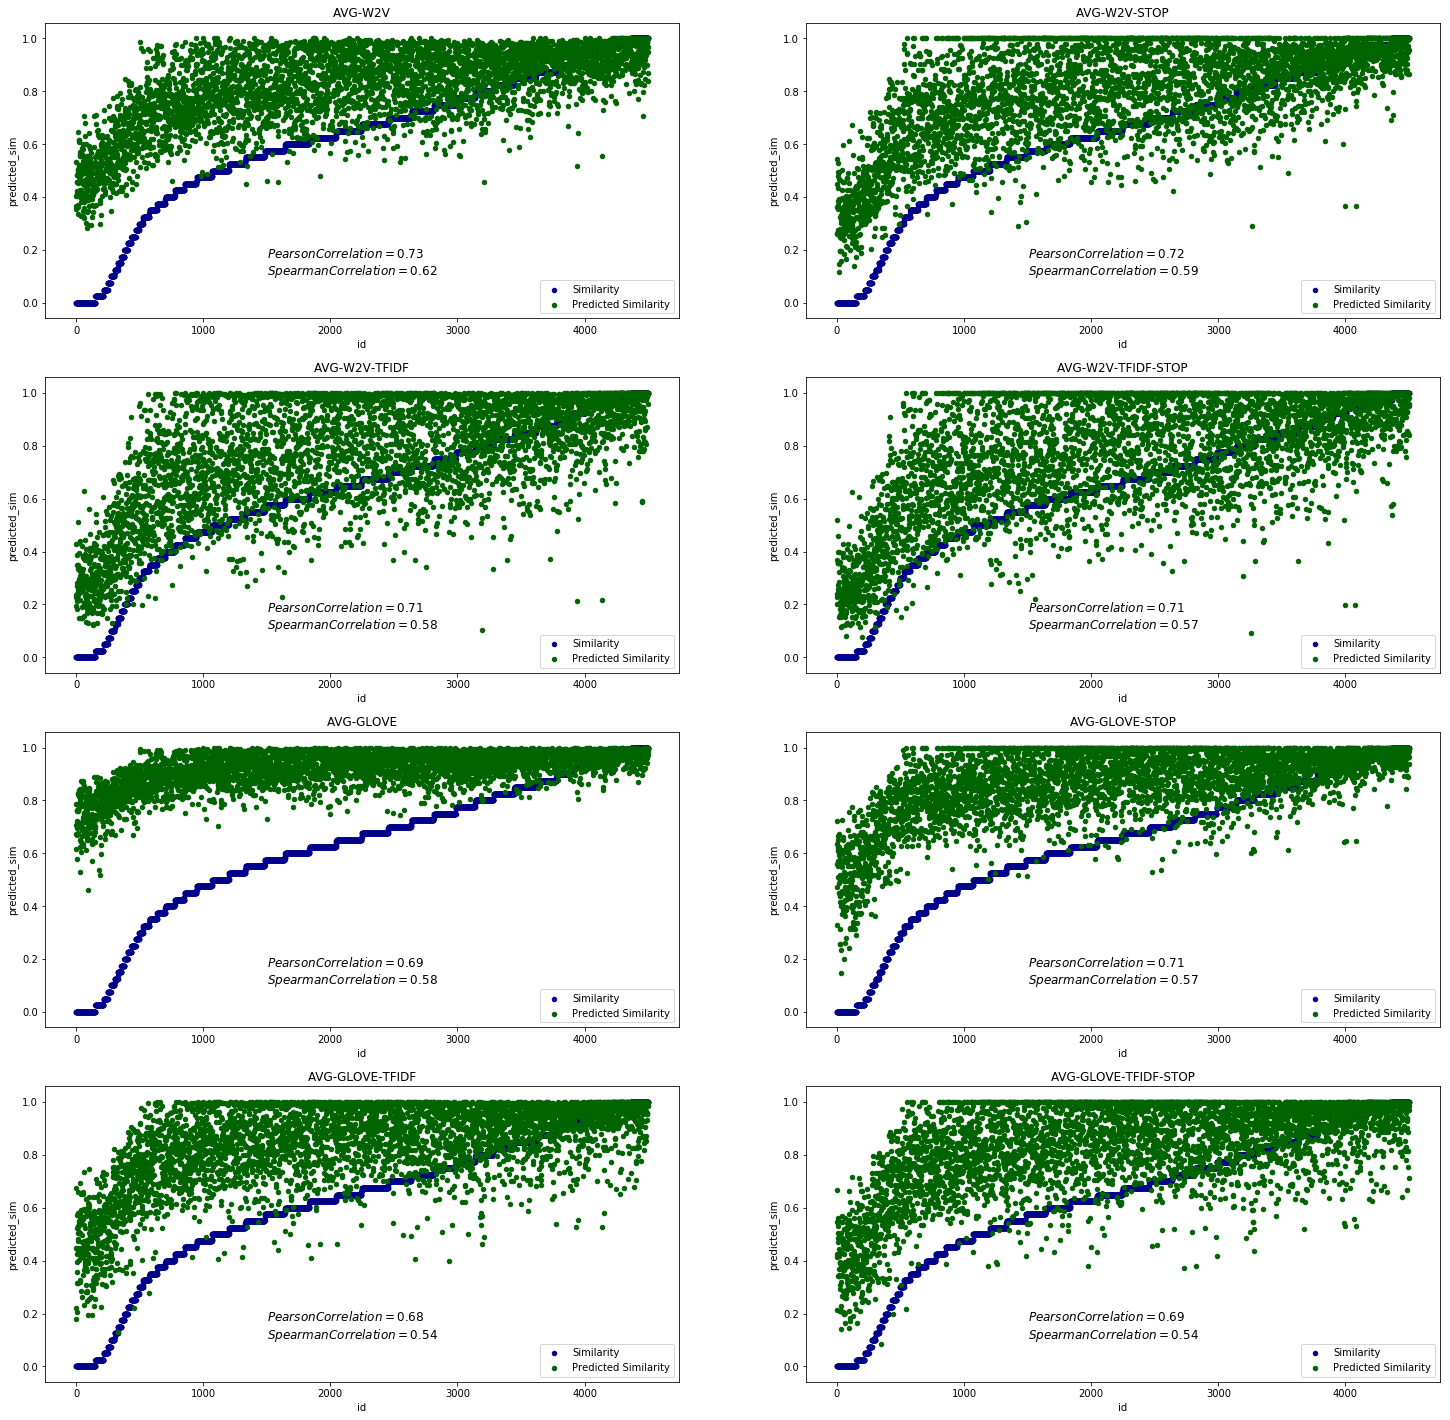

In [28]:
import scipy


fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25,25))
row = 0
column = 0
sick_train = normalize(sick_train, ["sim"])
for i in range(0, 8):
    sims, topic = run_experiment(sick_train, benchmarks[i])
    pearson_correlation = scipy.stats.pearsonr(sims, sick_train['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_train['sim'])[0]
    textstr = '$Pearson Correlation=%.2f$\n$Spearman Correlation=%.2f$'%(pearson_correlation, spearman_correlation)
    sick_train['predicted_sim'] = pd.Series(sims).values
    sick_train = sick_train.sort_values('sim')
    id = list(range(0, len(sick_train.index)))
    sick_train['id'] = pd.Series(id).values
    
    if(i < 2):
        row = 0
        column = i
    if(i >= 2 and i < 4):
        row = 1
        column = i-2
    if(i >= 4 and i < 6):
        row = 2
        column = i-4
    if(i >=6 and i < 8):
        row = 3
        column = i-6
        
    sick_train.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[row, column]);
    sick_train.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[row, column]);
    axes[row, column].text(1500, 0.1, textstr, fontsize=12)



Method was tested using STS data set. Only the dev sample was used. Pearson Correlation and Spearman Correlation was calcluated as before

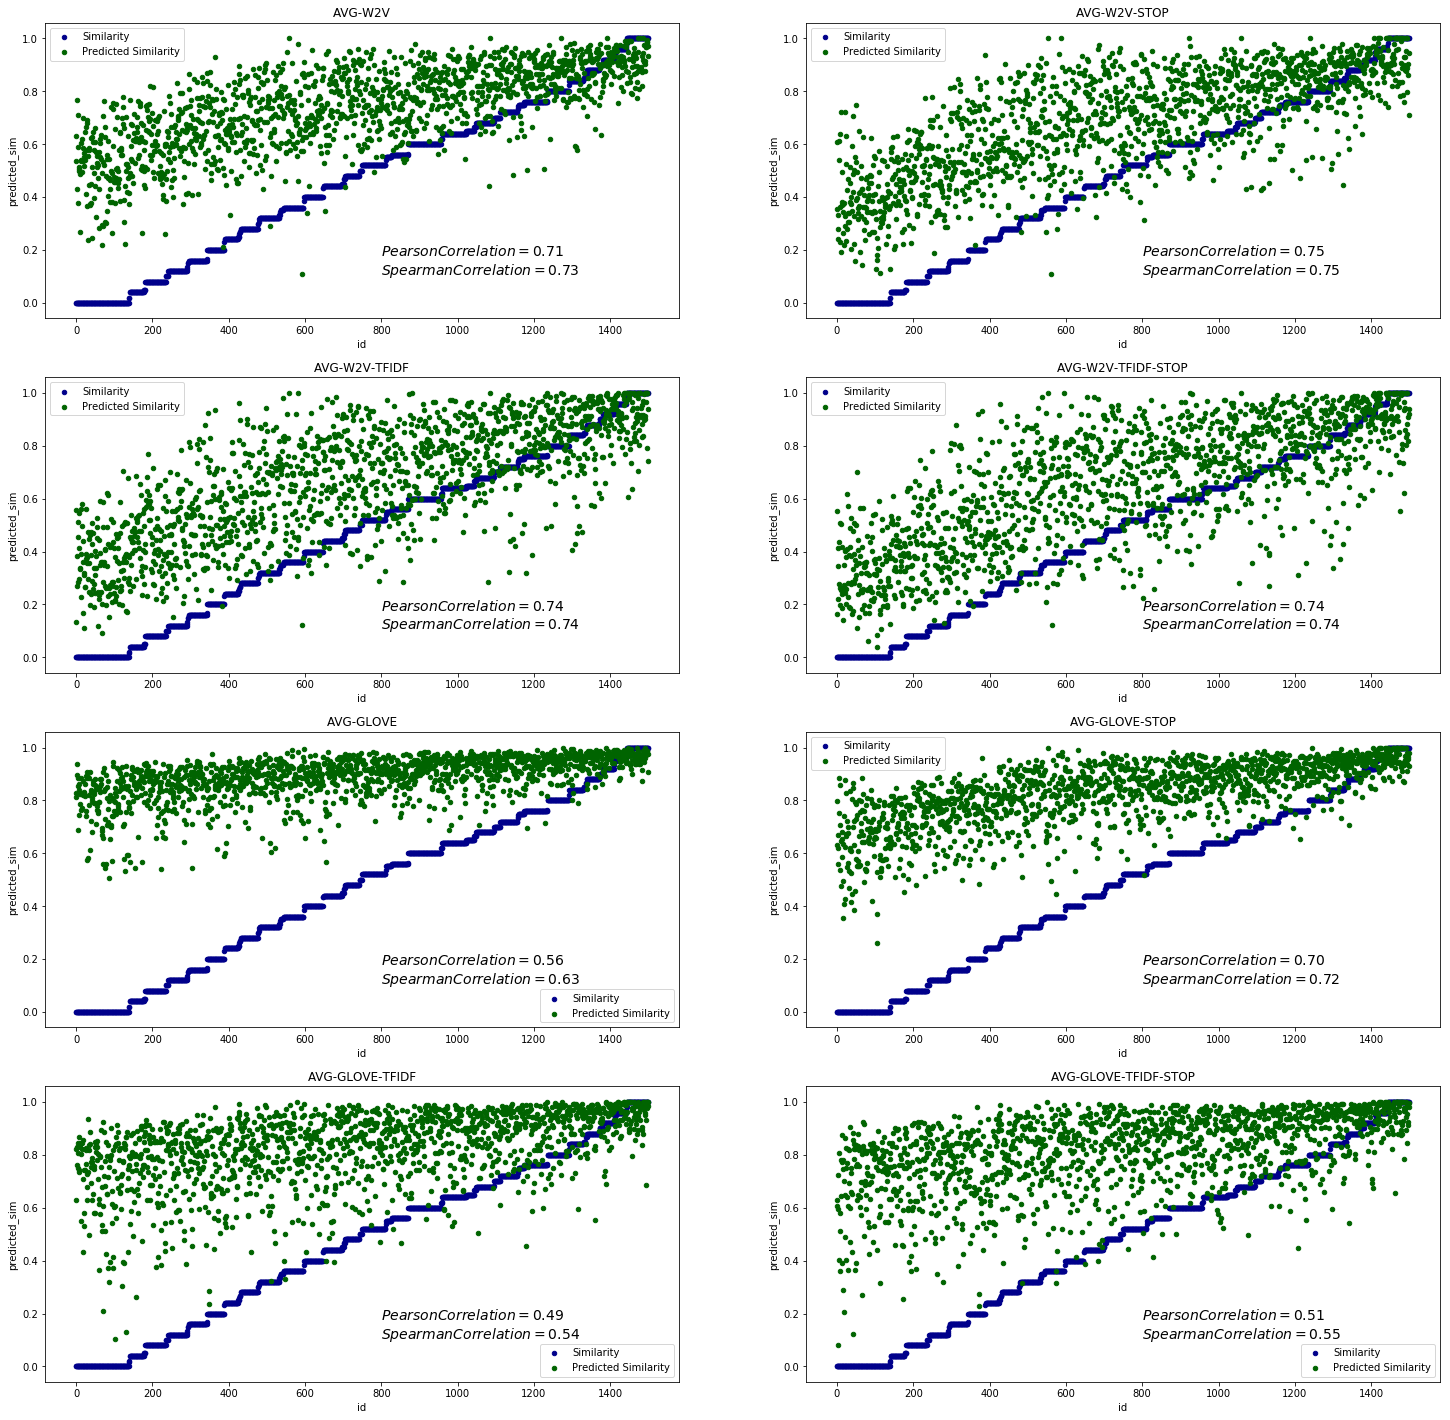

In [30]:
import scipy


fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25,25))
row = 0
column = 0
sts_dev = normalize(sts_dev, ["sim"])
for i in range(0, 8):
    sims, topic = run_experiment(sts_dev, benchmarks[i])
    pearson_correlation = scipy.stats.pearsonr(sims, sts_dev['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sts_dev['sim'])[0]
    textstr = '$Pearson Correlation=%.2f$\n$Spearman Correlation=%.2f$'%(pearson_correlation, spearman_correlation)
    sts_dev['predicted_sim'] = pd.Series(sims).values
    sts_dev = sts_dev.sort_values('sim')
    id = list(range(0, len(sts_dev.index)))
    sts_dev['id'] = pd.Series(id).values
    
    if(i < 2):
        row = 0
        column = i
    if(i >= 2 and i < 4):
        row = 1
        column = i-2
    if(i >= 4 and i < 6):
        row = 2
        column = i-4
    if(i >=6 and i < 8):
        row = 3
        column = i-6
        
    sts_dev.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[row, column]);
    sts_dev.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[row, column]);
    axes[row, column].text(800, 0.1, textstr, fontsize=14)

